In [1]:
import os
import json
import numpy as np
from numpy.linalg import norm
from scipy.interpolate import BSpline


# =========================================================
# 0) True beta functions + Simulation generator
# =========================================================

def true_beta_funcs_default(scales=None):
    """
    Ground-truth beta(t) functions, evaluated on raw t (global time).
    Keep consistent across all stages.
    """
    if scales is None:
        scales = [1.0, 1.0, 1.0, 1.0, 1.0]
    return [
        lambda t: scales[0] * (-0.5 + 0.6 * np.cos(2 * np.pi * t)),
        lambda t: scales[1] * (-0.5 + 0.6 * np.cos(2 * np.pi * t)),
        lambda t: scales[2] * (t - 0.5),
        lambda t: scales[3] * (0.7 * np.sin(4 * np.pi * t)),
        lambda t: scales[4] * (0.4 * np.cos(3 * np.pi * t)),
    ]


class VCMSimulator:
    """
    Simulation for VCM:
        y = sum_p X_p * beta_p(t) + sigma * eps
    only p in signal_idx have non-zero beta.
    """
    def __init__(self, P, signal_idx, beta_funcs, sigma,
                 seed_base=0, standardize_X=True):
        self.P = int(P)
        self.signal_idx = list(signal_idx)
        self.beta_funcs = list(beta_funcs)
        self.sigma = float(sigma)
        self.standardize_X = bool(standardize_X)

        # Segment-wise reproducibility: each segment uses deterministic seeds derived from seed_base + segment_id
        self.seed_base = int(seed_base)

    def sample_segment(self, a, b, n, segment_id):
        """
        Generate a segment dataset for t in [a,b].
        Deterministic per segment_id for reuse.
        """
        rng_t = np.random.default_rng(self.seed_base + 10_000 + segment_id)
        rng_x = np.random.default_rng(self.seed_base + 20_000 + segment_id)
        rng_e = np.random.default_rng(self.seed_base + 30_000 + segment_id)

        t = np.sort(rng_t.uniform(a, b, n))
        X = rng_x.standard_normal((n, self.P))
        if self.standardize_X:
            X = (X - X.mean(0)) / (X.std(0) + 1e-12)

        beta_true = np.zeros((n, self.P))
        for j, p in enumerate(self.signal_idx):
            beta_true[:, p] = self.beta_funcs[j % len(self.beta_funcs)](t)

        y = np.sum(X * beta_true, axis=1) + self.sigma * rng_e.standard_normal(n)
        return t, X, y, beta_true


# =========================================================
# 1) B-spline / VCM core utilities (consistent with your logic)
# =========================================================

def make_open_uniform_knots(a, b, k, n_inner):
    inner = np.linspace(a, b, n_inner + 2)[1:-1] if n_inner > 0 else np.array([])
    return np.r_[np.repeat(a, k + 1), inner, np.repeat(b, k + 1)]


def make_global_knots_piecewise_integer(a, b, k, n_inner_per_unit):
    """
    Generalize your Stage II knots2 construction to [0, T] with integer boundaries.
    - endpoints a/b: repeated (k+1)
    - each integer boundary (1,2,...,b-1) appears ONCE (as an interior knot)
    - each unit interval has n_inner_per_unit internal knots
    """
    a = float(a); b = float(b)
    if b <= a:
        raise ValueError("Require b > a.")
    a_int = int(round(a)); b_int = int(round(b))
    if abs(a - a_int) > 1e-12 or abs(b - b_int) > 1e-12:
        raise ValueError("This version assumes integer endpoints, e.g. 0,1,2,3...")

    knots = []
    knots.extend(np.repeat(a, k + 1).tolist())

    for s in range(a_int, b_int):
        L, R = float(s), float(s + 1)
        inner = np.linspace(L, R, n_inner_per_unit + 2)[1:-1]
        knots.extend(inner.tolist())

        boundary = float(s + 1)
        if boundary < b:
            knots.append(boundary)  # interior boundary, only once

    knots.extend(np.repeat(b, k + 1).tolist())
    return np.asarray(knots, dtype=float)


def bspline_design_matrix(x, knots, k):
    m = len(knots) - (k + 1)
    B = np.zeros((len(x), m))
    for j in range(m):
        c = np.zeros(m)
        c[j] = 1.0
        B[:, j] = BSpline(knots, c, k, extrapolate=False)(x)
    B[np.isnan(B)] = 0.0
    return B


def build_vcm_design(B, X):
    n, m = B.shape
    P = X.shape[1]
    out = np.zeros((n, m * P))
    for p in range(P):
        out[:, p * m:(p + 1) * m] = X[:, [p]] * B
    return out


def split_blocks(vec, m, P):
    return [vec[p * m:(p + 1) * m] for p in range(P)]


def gram_R(knots, k, a, b, grid=2500):
    gx = np.linspace(a, b, grid)
    B = bspline_design_matrix(gx, knots, k)
    w = np.ones(grid)
    w[0] *= 0.5
    w[-1] *= 0.5
    w *= (b - a) / (grid - 1)
    return B.T @ (B * w[:, None])


def group_weights(B, X):
    row_e = np.sum(B * B, axis=1)
    return np.sqrt((X ** 2 * row_e[:, None]).sum(0) / B.shape[0] + 1e-12)


def lambda_max_R(Phi, y, m, R):
    L = np.linalg.cholesky(R)
    P = Phi.shape[1] // m
    lam = 0.0
    for p in range(P):
        g = Phi[:, p * m:(p + 1) * m].T @ y
        u = np.linalg.solve(L.T, g)
        lam = max(lam, float(norm(u)))
    return lam


def group_soft_thresh(blocks, tau, R, lam, w):
    out = []
    for v, wp in zip(blocks, w):
        nr = float(np.sqrt(max(0.0, v.T @ R @ v)))
        thr = tau * lam * wp
        out.append(np.zeros_like(v) if nr <= thr else (1 - thr / nr) * v)
    return out


def fista_group_lasso(XtX, Xty, lam, m, P, R, w, max_iter=6000, tol=1e-7):
    d = m * P
    Ls = float(np.linalg.norm(XtX, 2))
    Ls = Ls if (np.isfinite(Ls) and Ls > 0) else 1.0
    step = 1.0 / Ls

    c = np.zeros(d)
    z = c.copy()
    tN = 1.0

    for _ in range(max_iter):
        grad = XtX @ z - Xty
        yv = z - step * grad
        yb = split_blocks(yv, m, P)
        c_new = np.concatenate(group_soft_thresh(yb, step, R, lam, w))

        t_new = 0.5 * (1 + np.sqrt(1 + 4 * tN * tN))
        z = c_new + (tN - 1) / t_new * (c_new - c)

        if norm(c_new - c) <= tol * max(1.0, norm(c)):
            return c_new
        c, tN = c_new, t_new

    return c


def kfold_indices(n, K=5, seed=2025):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    return np.array_split(idx, K)


def cv_select_lambda_plain(B, X, y, R, w, lam_path, K=5, seed=2025, use_1se=True):
    """
    Plain CV (Stage I style).
    """
    n = len(y)
    P = X.shape[1]
    m = B.shape[1]
    folds = kfold_indices(n, K, seed)
    mse = np.zeros((len(lam_path), K))

    for li, lam in enumerate(lam_path):
        for kf, val in enumerate(folds):
            tr = np.setdiff1d(np.arange(n), val)
            Btr, Bv = B[tr], B[val]
            Xtr, Xv = X[tr], X[val]
            ytr, yv = y[tr], y[val]

            Phi_tr = build_vcm_design(Btr, Xtr)
            Phi_v = build_vcm_design(Bv, Xv)

            c = fista_group_lasso(Phi_tr.T @ Phi_tr, Phi_tr.T @ ytr,
                                  float(lam), m, P, R, w)
            mse[li, kf] = np.mean((yv - Phi_v @ c) ** 2)

    mm = mse.mean(1)
    best = int(np.argmin(mm))
    if use_1se:
        se = mse.std(1, ddof=1) / np.sqrt(K)
        thr = mm[best] + se[best]
        best = int(np.where(mm <= thr)[0][0])

    return float(lam_path[best])


# =========================================================
# 2) Frozen-CV + basis matching (consistent with your Stage II)
# =========================================================

def map_unchanged_bases_by_span(knots_old, knots_new, k, t_cut, eps=1e-12):
    """
    Match old vs new bases by comparing their local knot spans (length k+1).
    Only keep bases whose right endpoint <= t_cut (old boundary).
    """
    t1 = np.asarray(knots_old, dtype=float)
    t2 = np.asarray(knots_new, dtype=float)
    m1 = len(t1) - (k + 1)
    m2 = len(t2) - (k + 1)

    S1 = np.stack([t1[i:i + k + 1] for i in range(m1)], axis=0)
    S2 = np.stack([t2[j:j + k + 1] for j in range(m2)], axis=0)

    cand1 = np.where(S1[:, -1] <= t_cut + eps)[0]
    cand2 = np.where(S2[:, -1] <= t_cut + eps)[0]

    pairs = []
    for i in cand1:
        a = S1[i]
        hit = np.where(np.all(np.abs(S2[cand2] - a) < eps, axis=1))[0]
        if hit.size == 1:
            pairs.append((int(i), int(cand2[hit[0]])))

    if not pairs:
        return np.array([], dtype=int), np.array([], dtype=int)

    idx_old, idx_new = zip(*pairs)
    return np.asarray(idx_old, dtype=int), np.asarray(idx_new, dtype=int)


def apply_relax(idx_new_matched, knots_new, k, r_relax):
    """
    Release r_relax bases closest to boundary from freezing.
    """
    idx_new_matched = np.asarray(idx_new_matched, dtype=int)
    if r_relax <= 0 or len(idx_new_matched) <= r_relax:
        return idx_new_matched, np.array([], dtype=int)

    right_end = np.array([knots_new[j + k] for j in idx_new_matched], dtype=float)
    order = np.argsort(right_end)

    move = np.zeros_like(idx_new_matched, dtype=bool)
    move[order[-r_relax:]] = True

    idx_o = idx_new_matched[~move]
    idx_relaxed = idx_new_matched[move]
    return idx_o, idx_relaxed


def cv_select_lambda_frozen(B_full, X, y, R_full, lam_path, idx_o, c_o_mat,
                            K=5, seed=2025, use_1se=True):
    """
    Frozen-CV for CN subproblem:
    - Frozen contribution uses (idx_o, c_o_mat) and is kept fixed per fold.
    - CN uses B[:, idx_cn] and residual y - frozen.
    """
    n_all, m_full = B_full.shape
    P = X.shape[1]
    folds = kfold_indices(n_all, K, seed)

    idx_all = np.arange(m_full, dtype=int)
    idx_cn = np.setdiff1d(idx_all, idx_o)

    mse = np.zeros((len(lam_path), K))

    for li, lam in enumerate(lam_path):
        for kf, val in enumerate(folds):
            tr = np.setdiff1d(np.arange(n_all), val)

            Btr, Bv = B_full[tr], B_full[val]
            Xtr, Xv = X[tr], X[val]
            ytr, yv = y[tr], y[val]

            Btr_o, Bv_o = Btr[:, idx_o], Bv[:, idx_o]
            Btr_cn, Bv_cn = Btr[:, idx_cn], Bv[:, idx_cn]

            frozen_tr = np.sum(Xtr * (Btr_o @ c_o_mat.T), axis=1)
            frozen_v = np.sum(Xv * (Bv_o @ c_o_mat.T), axis=1)

            ytr_res = ytr - frozen_tr

            R_cn = R_full[np.ix_(idx_cn, idx_cn)]
            w_cn = group_weights(Btr_cn, Xtr)

            Phi_tr = build_vcm_design(Btr_cn, Xtr)
            Phi_v = build_vcm_design(Bv_cn, Xv)

            c_cn = fista_group_lasso(Phi_tr.T @ Phi_tr, Phi_tr.T @ ytr_res,
                                     float(lam), Btr_cn.shape[1], P, R_cn, w_cn)

            y_pred = frozen_v + Phi_v @ c_cn
            mse[li, kf] = np.mean((yv - y_pred) ** 2)

    mm = mse.mean(1)
    best = int(np.argmin(mm))
    if use_1se:
        se = mse.std(1, ddof=1) / np.sqrt(K)
        thr = mm[best] + se[best]
        best = int(np.where(mm <= thr)[0][0])

    return float(lam_path[best])


def adaptive_cn_refit(B_cn, X, y_res, R_cn, lam_path,
                      seed_cv=2025, use_1se=True, eps=1e-6, delta=1.0):
    """
    One-step adaptive group-lasso in CN space:
    - warm fit (use weak lambda) -> r0 -> w_ad
    - CV over lam_path with w_ad
    - final refit
    """
    n = len(y_res)
    P = X.shape[1]
    m_cn = B_cn.shape[1]

    Phi = build_vcm_design(B_cn, X)

    # Warm fit: use the smallest lambda (weak penalty) as initialization
    lam_warm = float(lam_path[-1])
    w_warm = group_weights(B_cn, X)
    c0 = fista_group_lasso(Phi.T @ Phi, Phi.T @ y_res, lam_warm, m_cn, P, R_cn, w_warm)

    blocks0 = split_blocks(c0, m_cn, P)
    r0 = np.array([float(np.sqrt(max(0.0, b.T @ R_cn @ b))) for b in blocks0])
    w_ad = 1.0 / (r0 + eps) ** delta

    folds = kfold_indices(n, K=5, seed=seed_cv)
    mse = np.zeros((len(lam_path), 5))

    for li, lam in enumerate(lam_path):
        for kf, val in enumerate(folds):
            tr = np.setdiff1d(np.arange(n), val)
            Btr, Bv = B_cn[tr], B_cn[val]
            Xtr, Xv = X[tr], X[val]
            ytr, yv = y_res[tr], y_res[val]

            Phi_tr = build_vcm_design(Btr, Xtr)
            Phi_v = build_vcm_design(Bv, Xv)

            c_tmp = fista_group_lasso(Phi_tr.T @ Phi_tr, Phi_tr.T @ ytr,
                                      float(lam), m_cn, P, R_cn, w_ad)
            mse[li, kf] = np.mean((yv - Phi_v @ c_tmp) ** 2)

    mm = mse.mean(1)
    best = int(np.argmin(mm))
    if use_1se:
        se = mse.std(1, ddof=1) / np.sqrt(5)
        thr = mm[best] + se[best]
        best = int(np.where(mm <= thr)[0][0])

    lam_best = float(lam_path[best])
    c_final = fista_group_lasso(Phi.T @ Phi, Phi.T @ y_res, lam_best, m_cn, P, R_cn, w_ad)
    return lam_best, c_final


# =========================================================
# 3) Trainer with checkpoint (save/load) and strict stage recursion
# =========================================================

class IncrementalVCMTrainer:
    """
    Stage-wise incremental trainer:
    - Stage 1: fit on [0,1] (plain CV + group-lasso)
    - Stage s>1: extend to [0,s] by freezing O (unchanged bases up to s-1) and solving CN
      with frozen-CV and optional adaptive-CN.
    """

    def __init__(self, k, n_inner_per_unit, P,
                 seed_cv=2025, use_1se=True, r_relax=2):
        self.k = int(k)
        self.n_inner_per_unit = int(n_inner_per_unit)
        self.P = int(P)

        self.seed_cv = int(seed_cv)
        self.use_1se = bool(use_1se)
        self.r_relax = int(r_relax)

        # state
        self.t_end = None
        self.knots = None
        self.coef_blocks = None  # list of length P, each is (m,) array

        # cached data
        self.t_all = None
        self.X_all = None
        self.y_all = None

    # ---------- checkpoint I/O ----------
    def save_checkpoint(self, prefix_path):
        """
        Save: model state + accumulated data.
        Two files:
        - prefix_path.npz : arrays
        - prefix_path.json: meta
        """
        if self.t_end is None:
            raise RuntimeError("Nothing to save: trainer not fitted yet.")

        meta = dict(
            t_end=float(self.t_end),
            k=int(self.k),
            n_inner_per_unit=int(self.n_inner_per_unit),
            P=int(self.P),
            seed_cv=int(self.seed_cv),
            use_1se=bool(self.use_1se),
            r_relax=int(self.r_relax),
        )

        coef_mat = np.stack(self.coef_blocks, axis=0)  # (P, m)

        os.makedirs(os.path.dirname(prefix_path) or ".", exist_ok=True)
        np.savez_compressed(
            prefix_path + ".npz",
            t_all=self.t_all,
            X_all=self.X_all,
            y_all=self.y_all,
            knots=self.knots,
            coef_mat=coef_mat,
        )

        with open(prefix_path + ".json", "w", encoding="utf-8") as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)

    @classmethod
    def load_checkpoint(cls, prefix_path):
        with open(prefix_path + ".json", "r", encoding="utf-8") as f:
            meta = json.load(f)

        obj = cls(
            k=meta["k"],
            n_inner_per_unit=meta["n_inner_per_unit"],
            P=meta["P"],
            seed_cv=meta["seed_cv"],
            use_1se=meta["use_1se"],
            r_relax=meta["r_relax"],
        )

        pack = np.load(prefix_path + ".npz", allow_pickle=False)
        obj.t_all = pack["t_all"]
        obj.X_all = pack["X_all"]
        obj.y_all = pack["y_all"]
        obj.knots = pack["knots"]
        coef_mat = pack["coef_mat"]  # (P, m)
        obj.coef_blocks = [coef_mat[p].copy() for p in range(coef_mat.shape[0])]
        obj.t_end = float(meta["t_end"])
        return obj

    # ---------- core training ----------
    def fit_stage1(self, t, X, y):
        """
        Stage I: fit on [0,1].
        - knots: open clamped on [0,1], with n_inner_per_unit internal knots
        - CV to select lambda, then refit on full
        """
        self.t_end = 1.0
        self.t_all = np.asarray(t, dtype=float).copy()
        self.X_all = np.asarray(X, dtype=float).copy()
        self.y_all = np.asarray(y, dtype=float).copy()

        knots = make_open_uniform_knots(0.0, 1.0, self.k, self.n_inner_per_unit)
        B = bspline_design_matrix(self.t_all, knots, self.k)
        m = B.shape[1]

        Phi = build_vcm_design(B, self.X_all)
        R = gram_R(knots, self.k, 0.0, 1.0)
        w = group_weights(B, self.X_all)

        lam_max = lambda_max_R(Phi, self.y_all, m, R)
        lam_path = np.geomspace(lam_max, lam_max * 5e-4, 30)

        lam_best = cv_select_lambda_plain(
            B, self.X_all, self.y_all, R, w, lam_path,
            K=5, seed=self.seed_cv, use_1se=self.use_1se
        )

        c = fista_group_lasso(Phi.T @ Phi, Phi.T @ self.y_all, lam_best, m, self.P, R, w)
        self.knots = knots
        self.coef_blocks = split_blocks(c, m, self.P)

        yhat = self.predict(self.t_all, self.X_all)
        rmse = float(np.sqrt(np.mean((self.y_all - yhat) ** 2)))

        return dict(stage=1, t_end=1.0, m=m, lambda_best=float(lam_best), train_rmse=rmse)

    def extend_one_stage(self, next_end, t_seg, X_seg, y_seg, use_adaptive_cn=True):
        """
        Extend from current [0, t_end] to [0, next_end] (next_end = t_end + 1).
        Freeze unchanged bases O up to t_end, solve CN with frozen-CV and optional adaptive.
        """
        if self.t_end is None:
            raise RuntimeError("Call fit_stage1 first or load a checkpoint.")
        next_end = float(next_end)
        if next_end <= self.t_end + 1e-12:
            raise ValueError("next_end must be > current t_end.")

        # Append new segment data
        self.t_all = np.r_[self.t_all, np.asarray(t_seg, dtype=float)]
        self.X_all = np.vstack([self.X_all, np.asarray(X_seg, dtype=float)])
        self.y_all = np.r_[self.y_all, np.asarray(y_seg, dtype=float)]

        # New global knots and full design B
        knots_new = make_global_knots_piecewise_integer(0.0, next_end, self.k, self.n_inner_per_unit)
        B_full = bspline_design_matrix(self.t_all, knots_new, self.k)
        m_full = B_full.shape[1]

        # Map unchanged bases up to old boundary self.t_end
        idx_old_matched, idx_new_matched = map_unchanged_bases_by_span(self.knots, knots_new, self.k, t_cut=self.t_end)

        # Apply relax near boundary
        idx_new_o, idx_new_relaxed = apply_relax(idx_new_matched, knots_new, self.k, self.r_relax)

        # Build mapping new->old for matched indices, then filter old indices aligned with idx_new_o
        new2old = {int(j): int(i) for i, j in zip(idx_old_matched.tolist(), idx_new_matched.tolist())}
        idx_old_o = np.array([new2old[int(j)] for j in idx_new_o], dtype=int)

        # O/CN split under new basis
        idx_all = np.arange(m_full, dtype=int)
        idx_o = np.asarray(idx_new_o, dtype=int)
        idx_cn = np.setdiff1d(idx_all, idx_o)

        # Frozen coefficient matrix c_o_mat: (P, |O|)
        c_o_mat = np.stack([self.coef_blocks[p][idx_old_o].astype(float, copy=True) for p in range(self.P)], axis=0)

        # Frozen contribution and residual
        B_o = B_full[:, idx_o]
        frozen_y = np.sum(self.X_all * (B_o @ c_o_mat.T), axis=1)
        y_res = self.y_all - frozen_y

        # CN subproblem objects
        B_cn = B_full[:, idx_cn]
        R_full = gram_R(knots_new, self.k, 0.0, next_end)
        R_cn = R_full[np.ix_(idx_cn, idx_cn)]
        Phi_cn = build_vcm_design(B_cn, self.X_all)

        lam_max = lambda_max_R(Phi_cn, y_res, B_cn.shape[1], R_cn)
        lam_path = np.geomspace(lam_max, lam_max * 5e-4, 30)

        # Frozen-CV select lambda
        lam_best = cv_select_lambda_frozen(
            B_full, self.X_all, self.y_all, R_full, lam_path,
            idx_o=idx_o, c_o_mat=c_o_mat,
            K=5, seed=self.seed_cv, use_1se=self.use_1se
        )

        # Fit CN with selected lambda (initial CN solution)
        w_cn = group_weights(B_cn, self.X_all)
        c_cn = fista_group_lasso(Phi_cn.T @ Phi_cn, Phi_cn.T @ y_res,
                                 lam_best, B_cn.shape[1], self.P, R_cn, w_cn)

        lam_ad = None
        c_cn_use = c_cn

        # Optional adaptive refit on CN
        if use_adaptive_cn:
            lam_ad, c_cn_use = adaptive_cn_refit(
                B_cn, self.X_all, y_res, R_cn, lam_path,
                seed_cv=self.seed_cv, use_1se=self.use_1se
            )

        # Reassemble full coefficients in new basis
        blocks_cn = split_blocks(c_cn_use, B_cn.shape[1], self.P)
        coef_blocks_new = []
        for p in range(self.P):
            c_full = np.zeros(m_full, dtype=float)
            c_full[idx_o] = c_o_mat[p]
            c_full[idx_cn] = blocks_cn[p]
            coef_blocks_new.append(c_full)

        # Update state
        self.t_end = next_end
        self.knots = knots_new
        self.coef_blocks = coef_blocks_new

        # Diagnostics
        yhat = self.predict(self.t_all, self.X_all)
        rmse = float(np.sqrt(np.mean((self.y_all - yhat) ** 2)))

        return dict(
            stage=int(round(next_end)),
            t_end=float(next_end),
            m_full=int(m_full),
            num_frozen=int(len(idx_o)),
            num_cn=int(len(idx_cn)),
            relaxed_count=int(len(idx_new_relaxed)),
            lambda_best=float(lam_best),
            lambda_ad=(float(lam_ad) if lam_ad is not None else None),
            train_rmse=rmse,
        )

    def predict(self, t, X):
        t = np.asarray(t, dtype=float)
        X = np.asarray(X, dtype=float)
        B = bspline_design_matrix(t, self.knots, self.k)
        beta_hat = np.column_stack([B @ self.coef_blocks[p] for p in range(self.P)])
        return np.sum(X * beta_hat, axis=1)

    def eval_beta(self, t_grid):
        t_grid = np.asarray(t_grid, dtype=float)
        B = bspline_design_matrix(t_grid, self.knots, self.k)
        return np.column_stack([B @ self.coef_blocks[p] for p in range(self.P)])


# =========================================================
# 4) A driver: run stage-by-stage, with checkpoint reuse
# =========================================================

def run_or_resume_incremental(
    checkpoint_dir,
    t_final,
    n_per_segment,
    P,
    signal_idx,
    beta_funcs,
    sigma,
    k,
    n_inner_per_unit,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=True,
):
    """
    Stage-wise driver with checkpoint reuse:
    - If checkpoint for max existing stage exists, load it.
    - Then generate only missing segments and extend stage-by-stage.
    - Save checkpoint after each stage.

    Checkpoint naming:
      ckpt_t1, ckpt_t2, ..., where tX means fitted on [0, X].
    """
    os.makedirs(checkpoint_dir, exist_ok=True)

    def ckpt_path(t_end):
        return os.path.join(checkpoint_dir, f"ckpt_t{int(round(t_end))}")

    # Find the largest existing checkpoint <= t_final
    existing = []
    for s in range(1, int(round(t_final)) + 1):
        if os.path.exists(ckpt_path(s) + ".json") and os.path.exists(ckpt_path(s) + ".npz"):
            existing.append(s)

    sim = VCMSimulator(P=P, signal_idx=signal_idx, beta_funcs=beta_funcs, sigma=sigma,
                       seed_base=seed_data, standardize_X=True)

    if existing:
        start_end = float(max(existing))
        trainer = IncrementalVCMTrainer.load_checkpoint(ckpt_path(start_end))
        history = [{"loaded_from": ckpt_path(start_end), "t_end": trainer.t_end}]
    else:
        start_end = 0.0
        trainer = IncrementalVCMTrainer(k=k, n_inner_per_unit=n_inner_per_unit, P=P,
                                        seed_cv=seed_cv, use_1se=use_1se, r_relax=r_relax)
        history = []

    # If nothing exists, run Stage 1
    if start_end < 1.0 - 1e-12:
        t0, X0, y0, _ = sim.sample_segment(0.0, 1.0, n_per_segment, segment_id=0)
        info1 = trainer.fit_stage1(t0, X0, y0)
        trainer.save_checkpoint(ckpt_path(1.0))
        history.append(info1)
        start_end = 1.0

    # Extend stage-by-stage
    current_end = start_end
    while current_end < t_final - 1e-12:
        next_end = current_end + 1.0
        seg_id = int(round(current_end))  # segment [current_end, current_end+1]
        t_seg, X_seg, y_seg, _ = sim.sample_segment(current_end, next_end, n_per_segment, segment_id=seg_id)

        info = trainer.extend_one_stage(
            next_end, t_seg, X_seg, y_seg, use_adaptive_cn=use_adaptive_cn
        )
        trainer.save_checkpoint(ckpt_path(next_end))
        history.append(info)
        current_end = next_end

    return trainer, history


def select_groups_by_Rnorm(trainer, tol=1e-6):
    """
    Return selected group indices and their R-norms, consistent with your logic.
    """
    m = len(trainer.knots) - (trainer.k + 1)
    R = gram_R(trainer.knots, trainer.k, 0.0, trainer.t_end)  # consistent with current stage interval
    r = np.array([float(np.sqrt(max(0.0, cb.T @ R @ cb))) for cb in trainer.coef_blocks])
    selected = np.where(r > tol)[0].tolist()
    return selected, r

def export_selected_groups(trainer, tol=1e-6, max_coef_show=10):
    """
    Export selected groups:
    - group index p
    - R-norm r_p
    - coefficient vector (full)
    - coefficient preview (first max_coef_show entries)
    """
    selected, r = select_groups_by_Rnorm(trainer, tol=tol)

    out = []
    for p in selected:
        coef = trainer.coef_blocks[p].copy()
        out.append({
            "group": int(p),
            "r_norm": float(r[p]),
            "coef_preview": coef[:max_coef_show].tolist(),
            "coef_full": coef,  # keep as numpy array for later computation
        })

    # Sort by importance (descending r-norm)
    out.sort(key=lambda d: d["r_norm"], reverse=True)
    return out

def select_groups_by_Rnorm_interval(trainer, t_range, tol=1e-6, grid=2500):
    """
    Select groups by interval R-norm:
        r_p(a,b) = sqrt(c_p^T R_[a,b] c_p)
    where R_[a,b] = ∫_a^b B(t)B(t)^T dt.

    Parameters
    ----------
    trainer : IncrementalVCMTrainer
        Must have knots, k, coef_blocks, t_end.
    t_range : tuple(float, float)
        (a, b) interval for norm calculation.
    tol : float
        threshold for selection.
    grid : int
        numerical integration grid size.

    Returns
    -------
    selected : list[int]
    r : np.ndarray shape (P,)
    """
    a, b = map(float, t_range)
    if a > b:
        a, b = b, a

    # Clamp to model's domain [0, trainer.t_end]
    a = max(0.0, a)
    b = min(float(trainer.t_end), b)
    if b <= a:
        raise ValueError(f"Invalid interval after clamping: [{a}, {b}].")

    # Interval Gram matrix
    R_ab = gram_R(trainer.knots, trainer.k, a, b, grid=grid)

    r = np.array([float(np.sqrt(max(0.0, cb.T @ R_ab @ cb))) for cb in trainer.coef_blocks])
    selected = np.where(r > tol)[0].tolist()
    return selected, r


In [2]:
P = 100
signal_idx = [1,2,3,4,5]
beta_funcs = true_beta_funcs_default()
sigma = 0.1

trainer, history = run_or_resume_incremental(
    checkpoint_dir="checkpoints_vcm",
    t_final=3.0,
    n_per_segment=400,
    P=P,
    signal_idx=signal_idx,
    beta_funcs=beta_funcs,
    sigma=sigma,
    k=3,
    n_inner_per_unit=10,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=True,
)

for h in history:
    print(h)




{'loaded_from': 'checkpoints_vcm\\ckpt_t3', 't_end': 3.0}


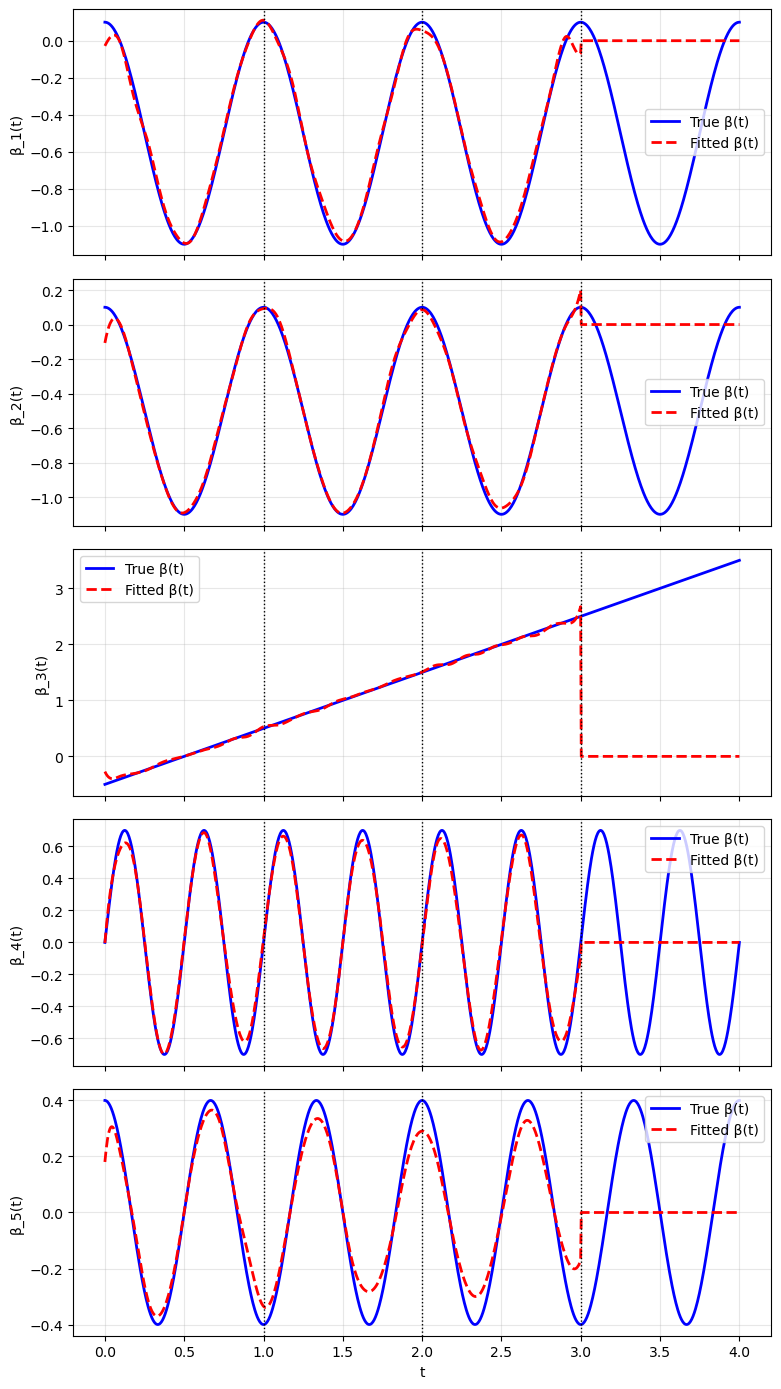

In [3]:
import matplotlib.pyplot as plt

t_grid = np.linspace(0, 4, 1000)
beta_hat = trainer.eval_beta(t_grid)

# True beta
beta_true = np.zeros_like(beta_hat)
for j, p in enumerate(signal_idx):
    beta_true[:, p] = beta_funcs[j % len(beta_funcs)](t_grid)

r = min(len(signal_idx), 5)
fig, axs = plt.subplots(r, 1, figsize=(8, 2.2*r+3), sharex=True)
for ax, p in zip(axs, signal_idx[:r]):
    ax.plot(t_grid, beta_true[:, p], 'b', lw=2, label='True β(t)')
    ax.plot(t_grid, beta_hat[:, p], 'r--', lw=2, label='Fitted β(t)')
    for cut in range(1, 4):
        ax.axvline(cut, color='k', ls=':', lw=1)
    ax.set_ylabel(f"β_{p}(t)")
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
axs[-1].set_xlabel("t")
plt.tight_layout()
plt.show()


In [4]:
trainer, history = run_or_resume_incremental(
    checkpoint_dir="checkpoints_vcm",
    t_final=4.0,
    n_per_segment=400,
    P=P,
    signal_idx=signal_idx,
    beta_funcs=beta_funcs,
    sigma=sigma,
    k=3,
    n_inner_per_unit=10,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=False,
)

for h in history:
    print(h)


{'loaded_from': 'checkpoints_vcm\\ckpt_t4', 't_end': 4.0}


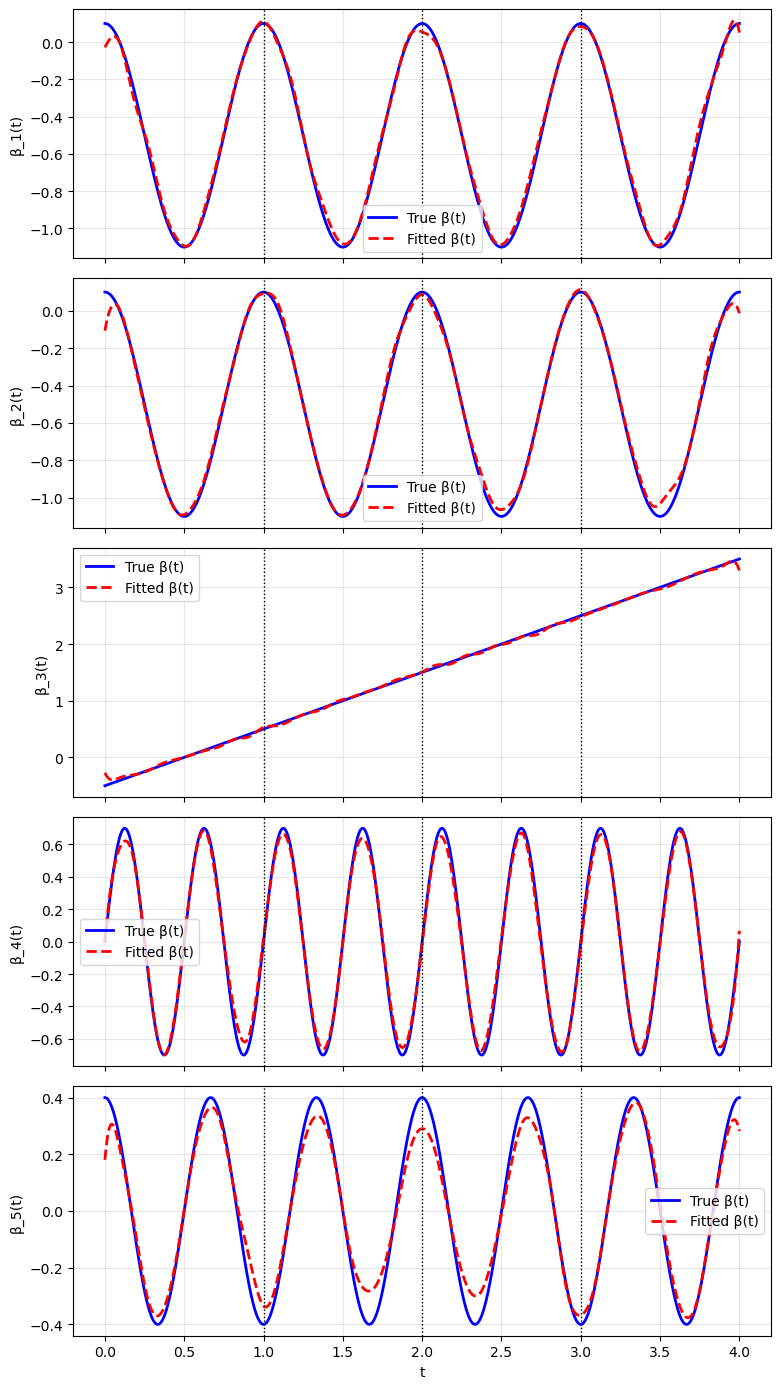

In [5]:
import matplotlib.pyplot as plt

t_grid = np.linspace(0, 4, 1000)
beta_hat = trainer.eval_beta(t_grid)

# True beta
beta_true = np.zeros_like(beta_hat)
for j, p in enumerate(signal_idx):
    beta_true[:, p] = beta_funcs[j % len(beta_funcs)](t_grid)

r = min(len(signal_idx), 5)
fig, axs = plt.subplots(r, 1, figsize=(8, 2.2*r+3), sharex=True)
for ax, p in zip(axs, signal_idx[:r]):
    ax.plot(t_grid, beta_true[:, p], 'b', lw=2, label='True β(t)')
    ax.plot(t_grid, beta_hat[:, p], 'r--', lw=2, label='Fitted β(t)')
    for cut in range(1, 4):
        ax.axvline(cut, color='k', ls=':', lw=1)
    ax.set_ylabel(f"β_{p}(t)")
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
axs[-1].set_xlabel("t")
plt.tight_layout()
plt.show()


In [6]:
trainer, history = run_or_resume_incremental(
    checkpoint_dir="checkpoints_vcm",
    t_final=6.0,
    n_per_segment=400,
    P=P,
    signal_idx=signal_idx,
    beta_funcs=beta_funcs,
    sigma=sigma,
    k=3,
    n_inner_per_unit=10,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=False,
)

for h in history:
    print(h)


{'loaded_from': 'checkpoints_vcm\\ckpt_t6', 't_end': 6.0}


In [7]:
def plot_beta(
    trainer,
    beta_funcs,
    signal_idx,
    t_range=None,
    n_grid=1000,
    show_cuts=True,
    max_plots=5,
):
    """
    Plot fitted vs true beta functions on a specified time interval.

    Parameters
    ----------
    trainer : IncrementalVCMTrainer
        Trained model with eval_beta(t) method.
    beta_funcs : list of callables
        True coefficient functions used in simulation.
    signal_idx : list[int]
        Indices of active groups.
    t_range : tuple(float, float), optional
        (t_start, t_end). Default: (0, trainer.t_end)
    n_grid : int
        Number of evaluation points.
    show_cuts : bool
        Whether to show stage cut lines at integers.
    max_plots : int
        Maximum number of beta curves to plot.
    """

    # -------- interval --------
    if t_range is None:
        t_start, t_end = 0.0, trainer.t_end
    else:
        t_start, t_end = t_range

    t_grid = np.linspace(t_start, t_end, n_grid)

    # -------- fitted beta --------
    beta_hat = trainer.eval_beta(t_grid)

    # -------- true beta --------
    beta_true = np.zeros_like(beta_hat)
    for j, p in enumerate(signal_idx):
        beta_true[:, p] = beta_funcs[j % len(beta_funcs)](t_grid)

    # -------- plotting --------
    r = min(len(signal_idx), max_plots)
    fig, axs = plt.subplots(r, 1, figsize=(8, 2.2*r + 3), sharex=True)

    if r == 1:
        axs = [axs]

    for ax, p in zip(axs, signal_idx[:r]):
        ax.plot(t_grid, beta_true[:, p], 'b', lw=2, label='True β(t)')
        ax.plot(t_grid, beta_hat[:, p], 'r--', lw=2, label='Fitted β(t)')

        if show_cuts:
            for cut in range(int(np.floor(t_start)) + 1,
                             int(np.ceil(t_end))):
                ax.axvline(cut, color='k', ls=':', lw=1)

        ax.set_ylabel(f"β_{p}(t)")
        ax.grid(alpha=0.3)
        ax.legend(loc='best')

    axs[-1].set_xlabel("t")
    plt.tight_layout()
    plt.show()


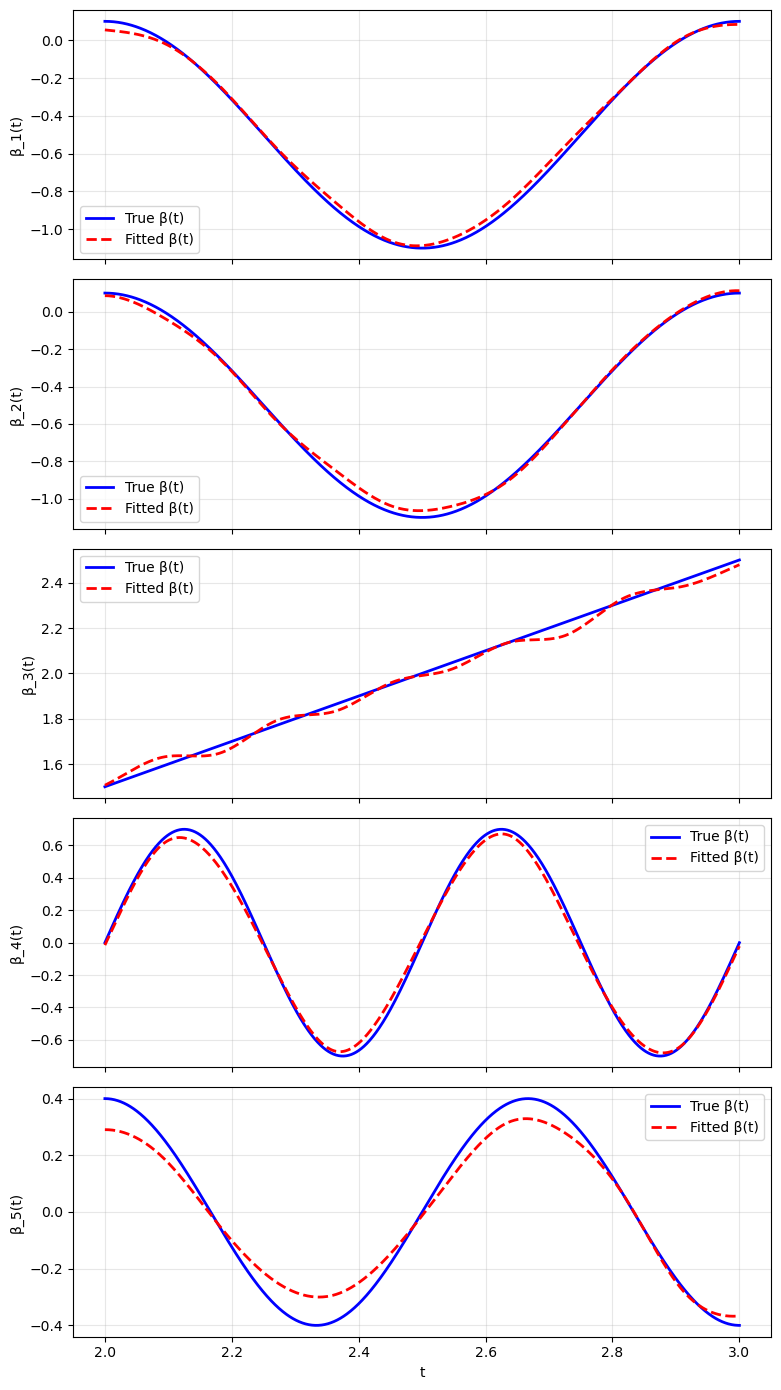

In [22]:
plot_beta(
    trainer,
    beta_funcs=beta_funcs,
    signal_idx=signal_idx,
    t_range=(2, 3),
)


In [9]:
trainer, history = run_or_resume_incremental(
    checkpoint_dir="checkpoints_vcm",
    t_final=8.0,
    n_per_segment=400,
    P=P,
    signal_idx=signal_idx,
    beta_funcs=beta_funcs,
    sigma=sigma,
    k=3,
    n_inner_per_unit=10,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=False,
)

for h in history:
    print(h)


{'loaded_from': 'checkpoints_vcm\\ckpt_t8', 't_end': 8.0}


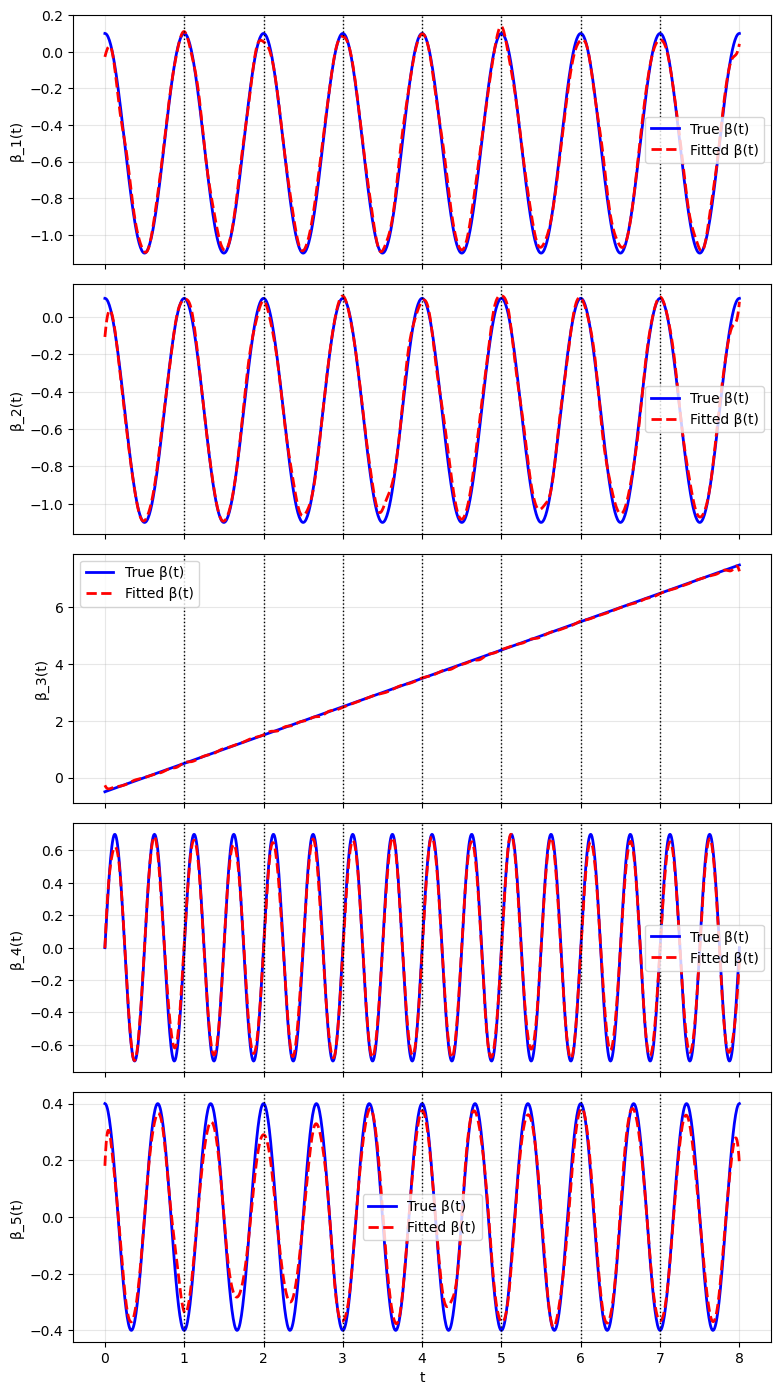

In [10]:
plot_beta(
    trainer,
    beta_funcs=beta_funcs,
    signal_idx=signal_idx,
    t_range=(0,8),
)


In [11]:
trainer, history = run_or_resume_incremental(
    checkpoint_dir="checkpoints_vcm",
    t_final=10.0,
    n_per_segment=400,
    P=P,
    signal_idx=signal_idx,
    beta_funcs=beta_funcs,
    sigma=sigma,
    k=3,
    n_inner_per_unit=10,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=False,
)

for h in history:
    print(h)

{'loaded_from': 'checkpoints_vcm\\ckpt_t10', 't_end': 10.0}


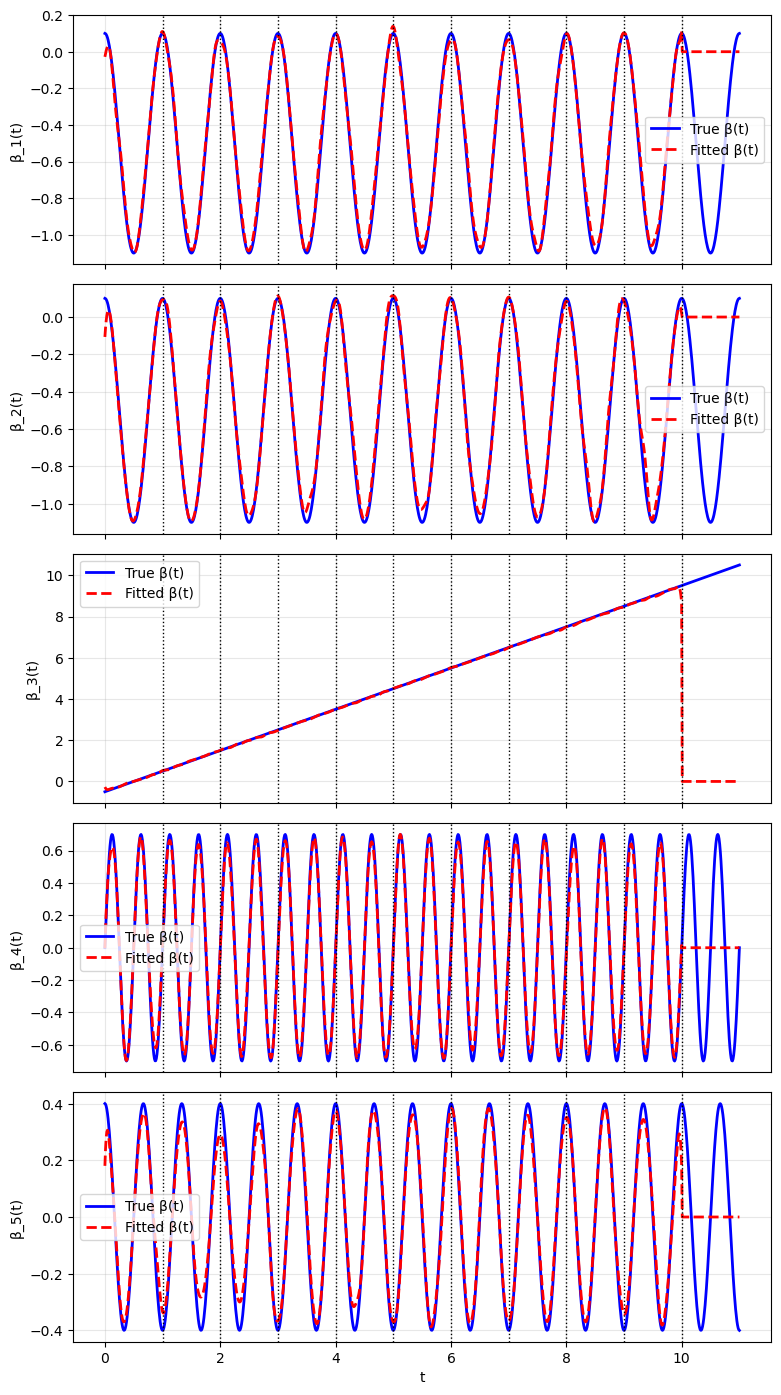

In [12]:
plot_beta(
    trainer,
    beta_funcs=beta_funcs,
    signal_idx=signal_idx,
    t_range=(0,11),
)


In [13]:
selected, r = select_groups_by_Rnorm(trainer, tol=1e-6)
print("Selected groups:", selected[:50])
print("Top-10 by r-norm:", sorted([(p, r[p]) for p in selected], key=lambda x: x[1], reverse=True)[:10])


Selected groups: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 16, 20, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 44, 46, 47, 48, 51, 52, 53, 54, 56, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
Top-10 by r-norm: [(3, 16.856970443990434), (1, 2.0171425163688794), (2, 2.015214365601655), (4, 1.4787686303516885), (5, 0.8024739871096697), (82, 0.008698503826441405), (98, 0.007272494293719006), (44, 0.00681145242779423), (90, 0.006683503525365251), (48, 0.006657844556972476)]


In [14]:
sel_last, r_last = select_groups_by_Rnorm_interval(trainer, (3.0, 4.0), tol=1e-6)
print("Selected on [3,4]:", sel_last[:50])


Selected on [3,4]: [0, 1, 2, 3, 4, 5, 20, 34, 38, 41, 52, 53, 56, 62, 65, 68, 77, 79, 84, 95, 96, 98, 99]


In [15]:
def select_groups_relative(r, rel=1e-3):
    # select those with r_p >= rel * max(r)
    thr = rel * float(np.max(r))
    sel = np.where(r >= thr)[0].tolist()
    return sel, thr

sel, r = select_groups_by_Rnorm_interval(trainer, (0.0, trainer.t_end), tol=0.0)
sel_rel, thr = select_groups_relative(r, rel=1e-3)
print("relative thr:", thr)
print("selected:", sel_rel)


relative thr: 0.016856970443990434
selected: [1, 2, 3, 4, 5]


In [16]:
trainer, history = run_or_resume_incremental(
    checkpoint_dir="checkpoints_vcm",
    t_final=11,
    n_per_segment=400,
    P=P,
    signal_idx=signal_idx,
    beta_funcs=beta_funcs,
    sigma=sigma,
    k=3,
    n_inner_per_unit=10,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=True,
)

for h in history:
    print(h)

{'loaded_from': 'checkpoints_vcm\\ckpt_t11', 't_end': 11.0}


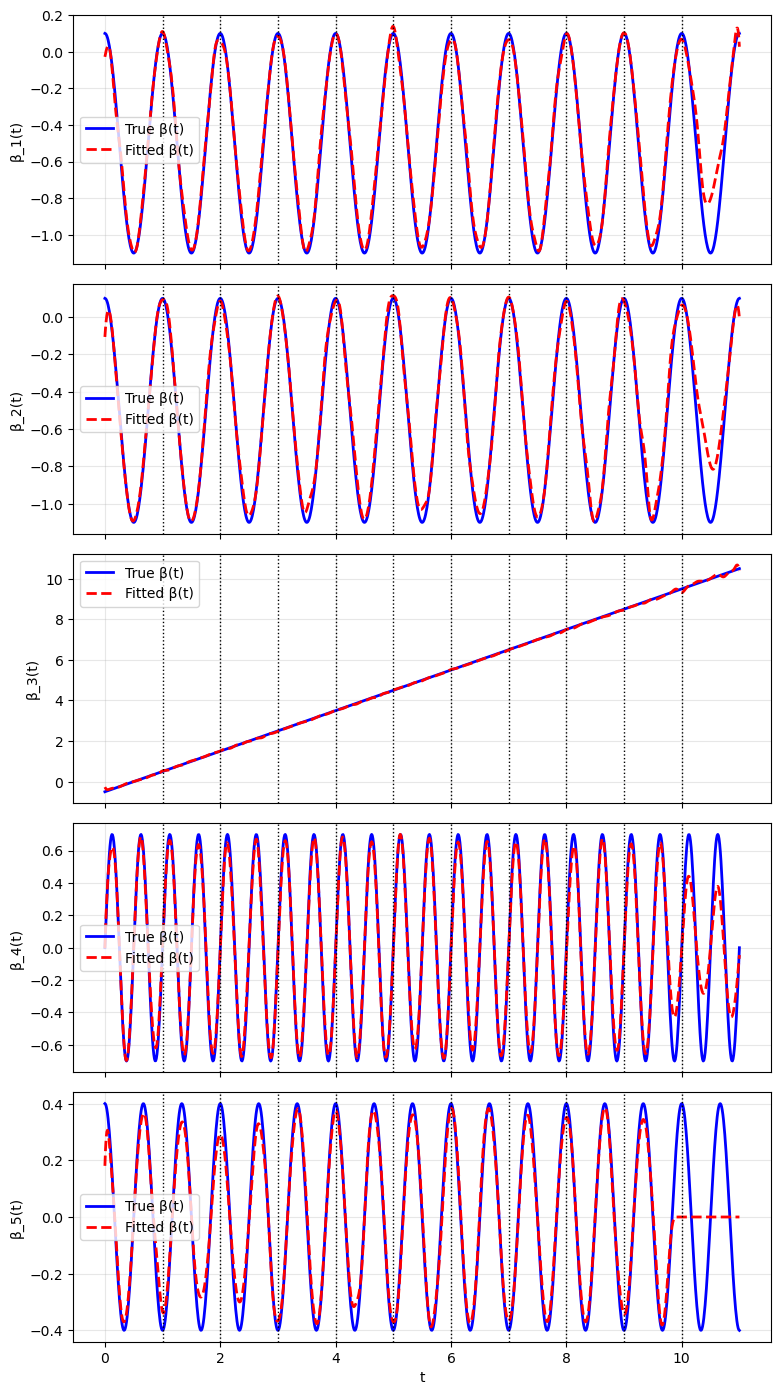

In [17]:
plot_beta(
    trainer,
    beta_funcs=beta_funcs,
    signal_idx=signal_idx,
    t_range=(0,11),
)


In [18]:
sel_last, r_last = select_groups_by_Rnorm_interval(trainer, (10.0, 11.0), tol=1e-6)
print("Selected on [10,11]:", sel_last[:50])


Selected on [10,11]: [1, 2, 3, 4]


{'loaded_from': 'checkpoints_vcm\\ckpt_t60', 't_end': 60.0}


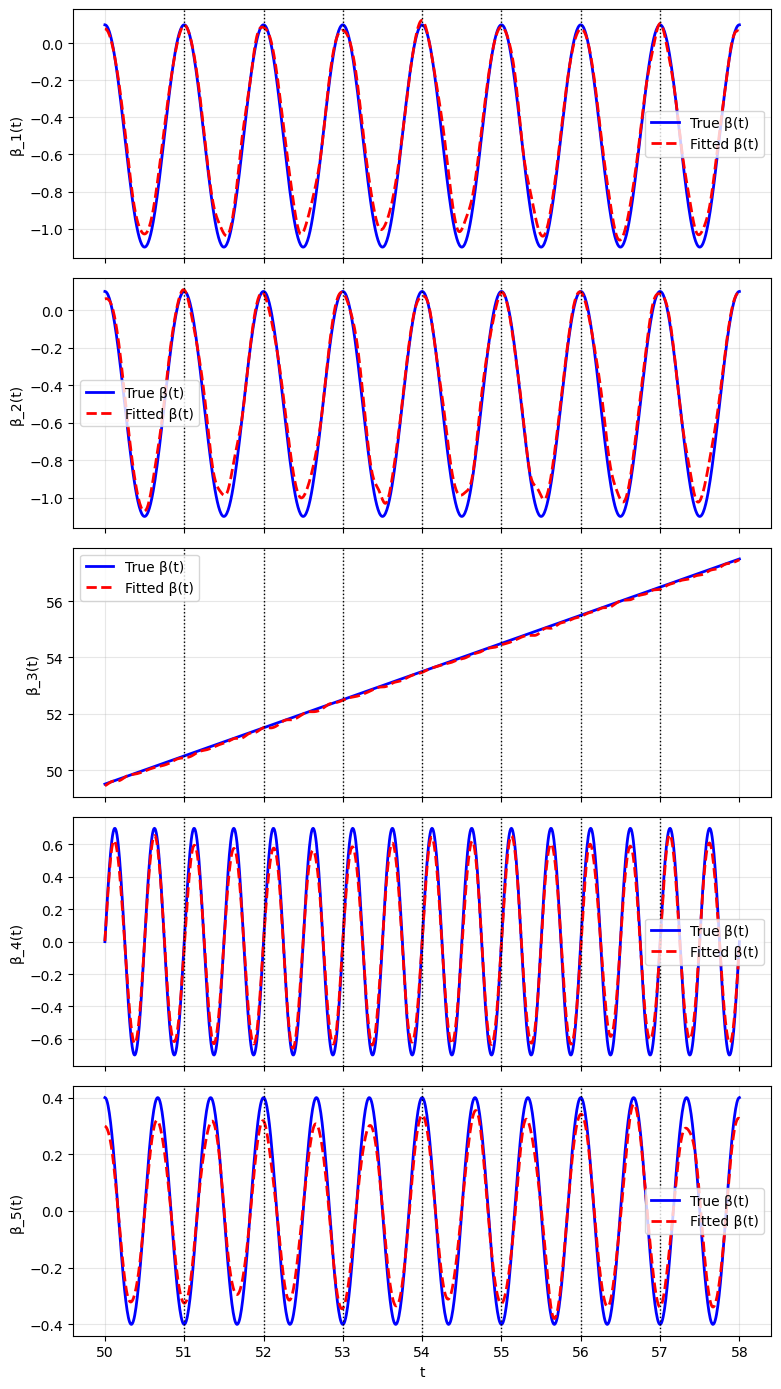

In [24]:
trainer, history = run_or_resume_incremental(
    checkpoint_dir="checkpoints_vcm",
    t_final=60,
    n_per_segment=400,
    P=P,
    signal_idx=signal_idx,
    beta_funcs=beta_funcs,
    sigma=sigma,
    k=3,
    n_inner_per_unit=10,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=True,
)

for h in history:
    print(h)

plot_beta(
    trainer,
    beta_funcs=beta_funcs,
    signal_idx=signal_idx,
    t_range=(50,58),
)
